<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        .header {
            background-color: #007bff; 
            color: white; 
            height: 150px; 
            display: flex; 
            justify-content: center; 
            align-items: center; 
            font-size: 36px; 
            font-weight: bold; 
            border-radius: 15px;
            margin-bottom: 40px; 
        }
    </style>
</head>
<body>
    <div class="header">
        Analyse et Prévision des Crimes à Los Angeles (2020 - Aujourd'hui)
    </div>
</body>
</html>


# <span style="color:#007bff">Importation des bibliothèques nécessaires</span>


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point

# <span style="color:#007bff">Chargement des Données</span>


In [2]:
# Charger les données
import pandas as pd

df = pd.read_csv(r"C:\Users\user\Downloads\Crime_Data_from_2020_to_Present.csv")


In [3]:
# Afficher les premières lignes
df.head()  

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


# <span style="color:#007bff">Contexte des Données de Criminalité à Los Angeles</span>


Depuis 2020, le département de police de Los Angeles (LAPD) compile et diffuse des données détaillées sur les incidents criminels survenus dans la ville. Ces données sont issues de rapports de criminalité qui ont été transcrits à partir de documents papier dactylographiés. Par conséquent, bien que ces informations soient utiles pour analyser les tendances criminelles, elles peuvent contenir certaines inexactitudes. De plus, certaines données relatives à la localisation sont parfois manquantes, représentées par des coordonnées géographiques par défaut (0°, 0°), et les adresses sont fournies uniquement jusqu'au bloc de cent le plus proche afin de préserver la confidentialité des victimes et des lieux.

Le LAPD met actuellement en œuvre un système de gestion des dossiers pour se conformer aux exigences du FBI concernant la collecte des données NIBRS (National Incident-Based Reporting System). À partir du 7 mars 2024, les utilisateurs verront exclusivement les incidents signalés dans l'ancien système. Le LAPD travaille activement à la génération de nouveaux ensembles de données NIBRS pour offrir un système de signalisation plus fluide et plus efficace. Toutefois, des problèmes techniques ont temporairement ralenti la mise à jour des données, ce qui explique les mises à jour hebdomadaires réduites.

---

# <span style="color:#007bff">Structure du Jeu de Données</span>


Cet ensemble de données contient plusieurs colonnes représentant différentes informations relatives aux crimes signalés à Los Angeles. Voici une description détaillée des principales colonnes présentes dans le jeu de données :

**DR_NO :** Numéro de rapport du crime.

**Date Rptd :** Date à laquelle le crime a été signalé.

**DATE OCC :** Date à laquelle le crime a eu lieu.

**TIME OCC :** Heure à laquelle le crime a eu lieu.

**AREA :** Numéro de la zone où le crime s'est produit.

**AREA NAME :** Nom de la zone où le crime s'est produit.

**Rpt Dist No :** Numéro de rapport de district.

**Part 1-2 :** Indication s'il s'agit d'un crime de première ou de deuxième partie.

**Crm Cd :** Code de classification du crime.

**Crm Cd Desc :** Description du code de classification du crime.

**Mocodes :** Codes de motifs ou de circonstances liés au crime.

**Vict Age :** Âge de la victime.

**Vict Sex :** Sexe de la victime.

**Vict Descent :** Origine ethnique ou descente de la victime.

**Premis Cd :** Code de classification de la localisation du crime.

**Premis Desc :** Description de la localisation du crime.

**Weapon Used Cd :** Code de l'arme utilisée, le cas échéant.

**Weapon Desc :** Description de l'arme utilisée, le cas échéant.

**Status :** Statut du crime.

**Status Desc :** Description du statut du crime.

**Crm Cd 1, Crm Cd 2, Crm Cd 3, Crm Cd 4 :** Codes de classification de crimes supplémentaires, le cas échéant.

**LOCATION :** Coordonnées géographiques de l'endroit où le crime s'est produit.

**Cross Street :** Rue transversale ou intersection où le crime s'est produit.

**LAT :** Latitude de l'endroit du crime.

**LON :** Longitude de l'endroit du crime.



## <span style="color:#007bff">Informations sur les colonnes et types de données </span>


In [4]:
# Obtenir des informations sur les colonnes et les types de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984045 entries, 0 to 984044
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           984045 non-null  int64  
 1   Date Rptd       984045 non-null  object 
 2   DATE OCC        984045 non-null  object 
 3   TIME OCC        984045 non-null  int64  
 4   AREA            984045 non-null  int64  
 5   AREA NAME       984045 non-null  object 
 6   Rpt Dist No     984045 non-null  int64  
 7   Part 1-2        984045 non-null  int64  
 8   Crm Cd          984045 non-null  int64  
 9   Crm Cd Desc     984045 non-null  object 
 10  Mocodes         837566 non-null  object 
 11  Vict Age        984045 non-null  int64  
 12  Vict Sex        844481 non-null  object 
 13  Vict Descent    844471 non-null  object 
 14  Premis Cd       984031 non-null  float64
 15  Premis Desc     983489 non-null  object 
 16  Weapon Used Cd  324280 non-null  float64
 17  Weapon Des

## <span style="color:#007bff">Statistiques descriptives </span>


In [5]:
# Vérifier les statistiques descriptives
df.describe()

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,9.840450e+05,984045.000000,984045.000000,984045.000000,984045.000000,984045.000000,984045.000000,984031.000000,324280.000000,984034.000000,68786.000000,2304.000000,61.000000,984045.000000,984045.000000
mean,2.192183e+08,1339.757607,10.660612,1112.462963,1.403121,500.923384,28.970099,305.744520,364.594804,500.682142,957.901390,985.506944,990.868852,34.004276,-118.110474
std,1.386970e+07,651.217198,6.124259,612.521969,0.490525,205.652092,21.999488,219.021428,123.189312,205.450848,110.811669,48.674216,27.690236,1.550811,5.373706
min,8.170000e+02,1.000000,1.000000,101.000000,1.000000,110.000000,-4.000000,101.000000,101.000000,110.000000,210.000000,310.000000,821.000000,0.000000,-118.667600
25%,2.020132e+08,900.000000,5.000000,583.000000,1.000000,331.000000,0.000000,101.000000,311.000000,331.000000,998.000000,998.000000,998.000000,34.015900,-118.431200
50%,2.209094e+08,1420.000000,11.000000,1133.000000,1.000000,442.000000,30.000000,203.000000,400.000000,442.000000,998.000000,998.000000,998.000000,34.059500,-118.323500
75%,2.310158e+08,1900.000000,16.000000,1619.000000,2.000000,626.000000,44.000000,501.000000,400.000000,626.000000,998.000000,998.000000,998.000000,34.164900,-118.273900
max,2.499289e+08,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,976.000000,516.000000,956.000000,999.000000,999.000000,999.000000,34.334300,0.000000


### <span style="color:#007bff">Colonnes à supprimer et pourquoi</span>


**DR_NO** : Il s'agit du numéro de rapport du crime, ce qui peut être utile pour l'identification unique des incidents. Cependant, il peut ne pas fournir d'informations significatives pour notre analyse.

**Rpt Dist No** : Il s'agit du numéro de rapport de district, qui pourrait être moins important pour l'analyse des tendances criminelles à l'échelle de la ville.

**Crm Cd 1, Crm Cd 2, Crm Cd 3, Crm Cd 4** : Ce sont des codes de classification de crimes supplémentaires. Si nous ne prévoyons pas d'analyser spécifiquement ces colonnes, elles pourraient être moins pertinentes.

**LOCATION et Cross Street** : Si nous avons déjà les coordonnées géographiques (LAT et LON), ces colonnes pourraient être redondantes.

**Premis Cd** : Si nous n'avons pas besoin d'informations détaillées sur le type de localisation où le crime s'est produit, cette colonne pourrait être moins importante.

In [6]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['DR_NO', 'Rpt Dist No', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'Premis Cd']

# Supprimer les colonnes
df = df.drop(colonnes_a_supprimer, axis=1)

# <span style="color:#007bff">Analyse des attributs</span>


- ### <span style="color:#007bff">Répartition par sexe des victimes</span>


Vict Sex
M    396647
F    351180
X     96550
H       103
-         1
Name: count, dtype: int64


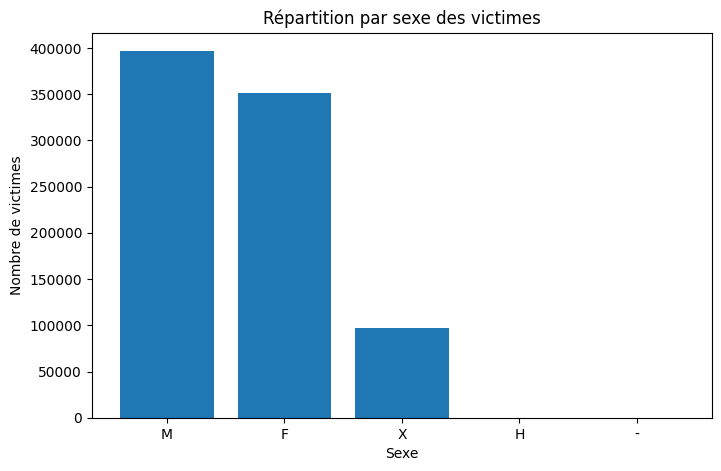

In [7]:
# Analyse de la colonne 'Vict Sex' (Sexe des victimes)
print(df['Vict Sex'].value_counts())

# Compter les occurrences de chaque catégorie dans 'Vict Sex'
counts = df['Vict Sex'].value_counts()

# Créer un graphique à barres pour représenter les données
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values)
plt.title('Répartition par sexe des victimes')
plt.xlabel('Sexe')
plt.ylabel('Nombre de victimes')
plt.show()

#### Résultats observés
La majorité des victimes sont de sexe masculin (396 647), suivis par les victimes de sexe féminin (351 180). 
Le code 'X' pourrait représenter des données manquantes ou indéterminées, tandis que les occurrences pour 'H' et '-' sont très faibles, 
suggérant des anomalies ou des erreurs dans les données.


- ### <span style="color:#007bff"> Répartition des crimes par zone (variable 'AREA NAME')</span>


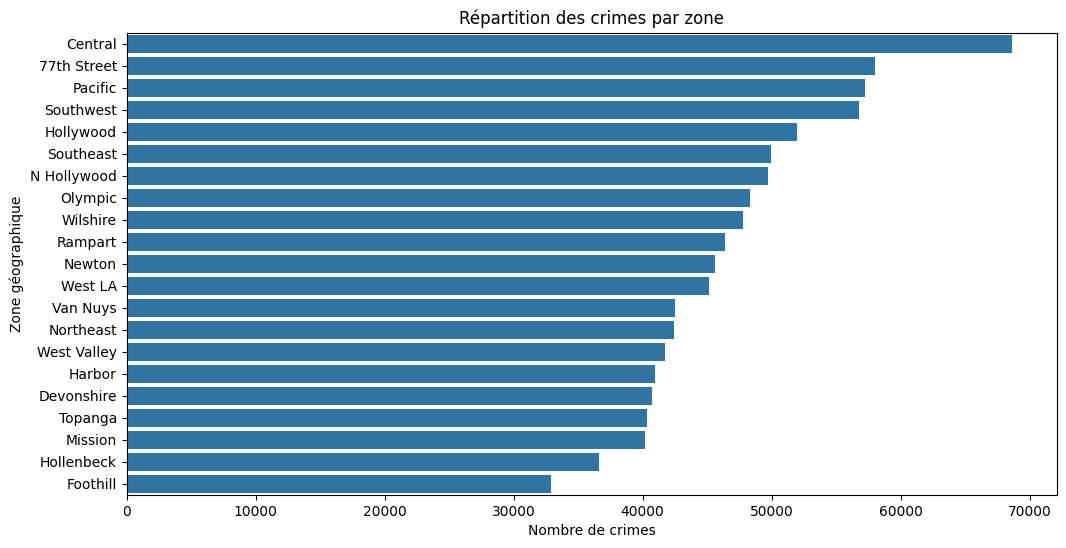

In [8]:
# Analyse de la répartition des crimes par zone

plt.figure(figsize=(12, 6))
sns.countplot(y='AREA NAME', data=df, order=df['AREA NAME'].value_counts().index)
plt.title('Répartition des crimes par zone')
plt.xlabel('Nombre de crimes')
plt.ylabel('Zone géographique')
plt.show()

- ### <span style="color:#007bff">Type de crime le plus fréquent (variable 'Crm Cd Desc')</span>


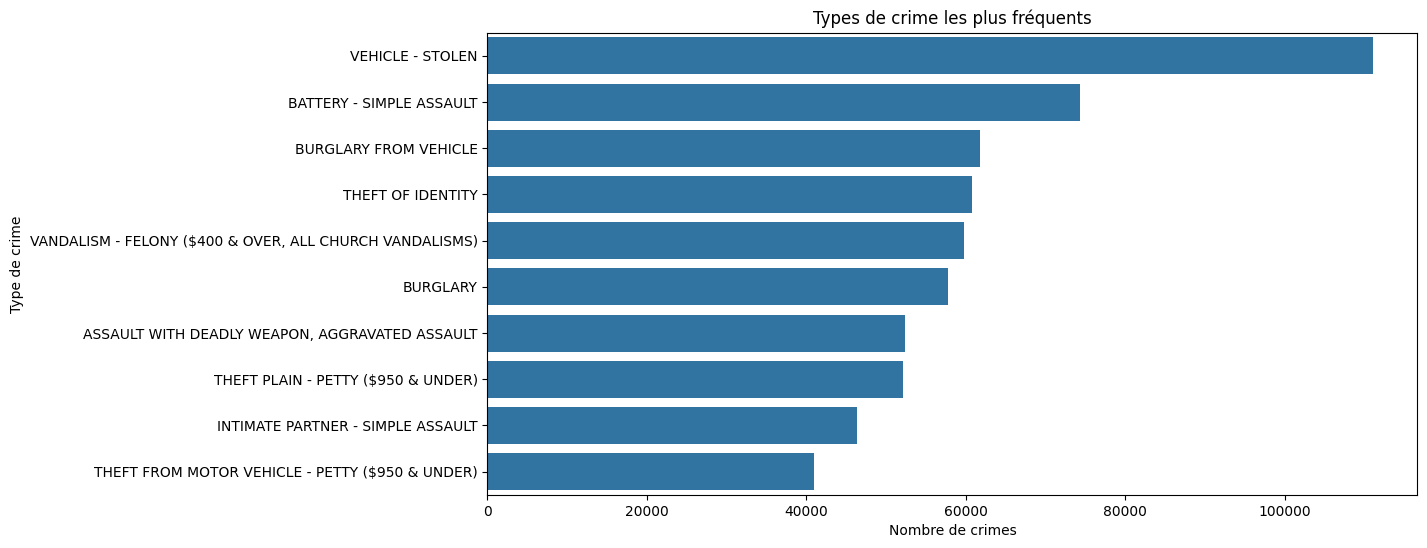

In [9]:
# Analyse du type de crime le plus fréquent
plt.figure(figsize=(12, 6))
top_crime_types = df['Crm Cd Desc'].value_counts().head(10)
sns.barplot(x=top_crime_types.values, y=top_crime_types.index)
plt.title('Types de crime les plus fréquents')
plt.xlabel('Nombre de crimes')
plt.ylabel('Type de crime')
plt.show()


# <span style="color:#007bff">Relations entre attributs</span>


- ### <span style="color:#007bff">Gestion d'âge qui contient des valeurs négatives et zéro</span>


In [10]:
# Remplacer les âges négatifs ou égaux à zéro par la médiane de l'âge des victimes
median_age = df[df['Vict Age'] > 0]['Vict Age'].median()
df['Vict Age'] = df['Vict Age'].apply(lambda x: x if x > 0 else median_age)
# Remplacer les valeurs manquantes par la moyenne 
df['Vict Age'].fillna(df['Vict Age'].mean(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_30436\3841955521.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Vict Age'].fillna(df['Vict Age'].mean(), inplace=True)


Le code a pour but de nettoyer la colonne 'Vict Age' en traitant deux problèmes courants dans les données :

1. **Remplacement des âges négatifs ou égaux à zéro** : Ces valeurs sont considérées comme des anomalies, car un âge ne peut pas être inférieur ou égal à zéro. Le code remplace donc ces âges par la médiane des âges des victimes dont l'âge est supérieur à zéro. Cela permet de maintenir la validité statistique de la distribution des âges.
  
2. **Remplacement des valeurs manquantes** : Les valeurs manquantes dans la colonne 'Vict Age' sont remplacées par la moyenne des âges des victimes. Cela permet de remplir les cases vides sans introduire de biais majeur dans l'analyse des données.

Ces deux étapes sont des pratiques courantes pour traiter les valeurs aberrantes et manquantes dans les ensembles de données, assurant ainsi des analyses plus fiables.


- ### <span style="color:#007bff">Relation entre l'âge des victimes et le sexe</span>


C:\Users\user\AppData\Local\Temp\ipykernel_30436\2195988628.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Vict Sex', y='Vict Age', data=df, palette='Pastel1')


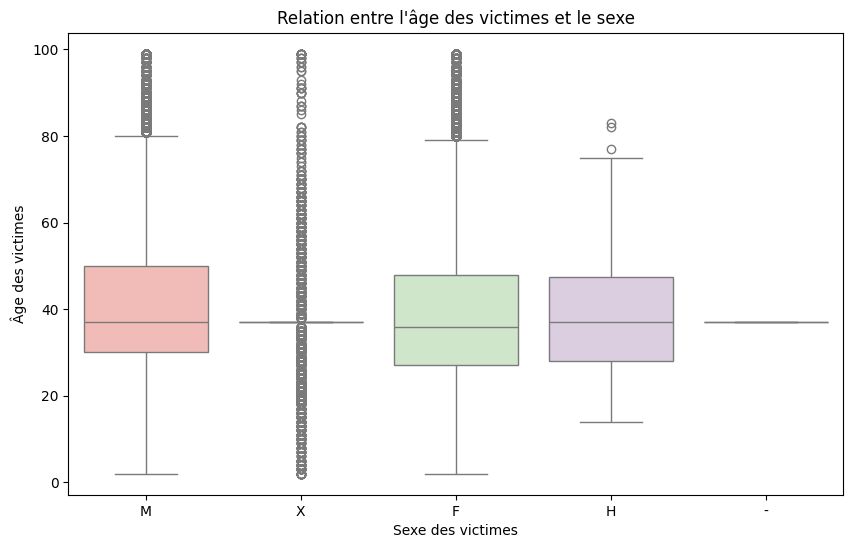

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vict Sex', y='Vict Age', data=df, palette='Pastel1')
plt.title('Relation entre l\'âge des victimes et le sexe')
plt.xlabel('Sexe des victimes')
plt.ylabel('Âge des victimes')
plt.show()


- ### <span style="color:#007bff">Relation entre l'âge des victimes et l'arme utilisée</span>


C:\Users\user\AppData\Local\Temp\ipykernel_30436\3161290303.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weapon Desc', y='Vict Age', data=df, palette='Dark2')


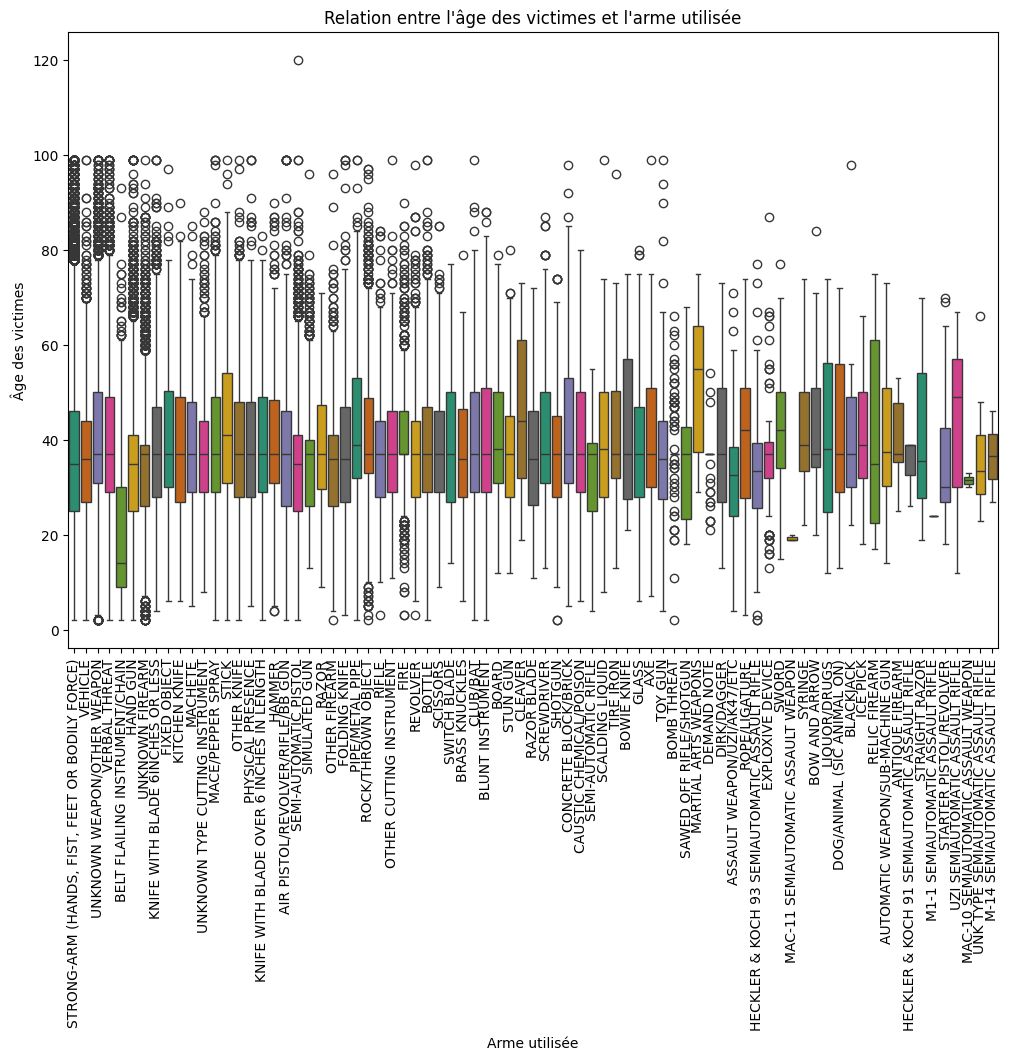

In [12]:
# Utilisation d'une palette de couleurs prédéfinie (par exemple, "Dark2")
plt.figure(figsize=(12, 8))
sns.boxplot(x='Weapon Desc', y='Vict Age', data=df, palette='Dark2')
plt.title('Relation entre l\'âge des victimes et l\'arme utilisée')
plt.xlabel('Arme utilisée')
plt.ylabel('Âge des victimes')
plt.xticks(rotation=90)
plt.show()





- ### <span style="color:#007bff">Relation entre l\'origine ethnique des victimes et le type de crime</span>


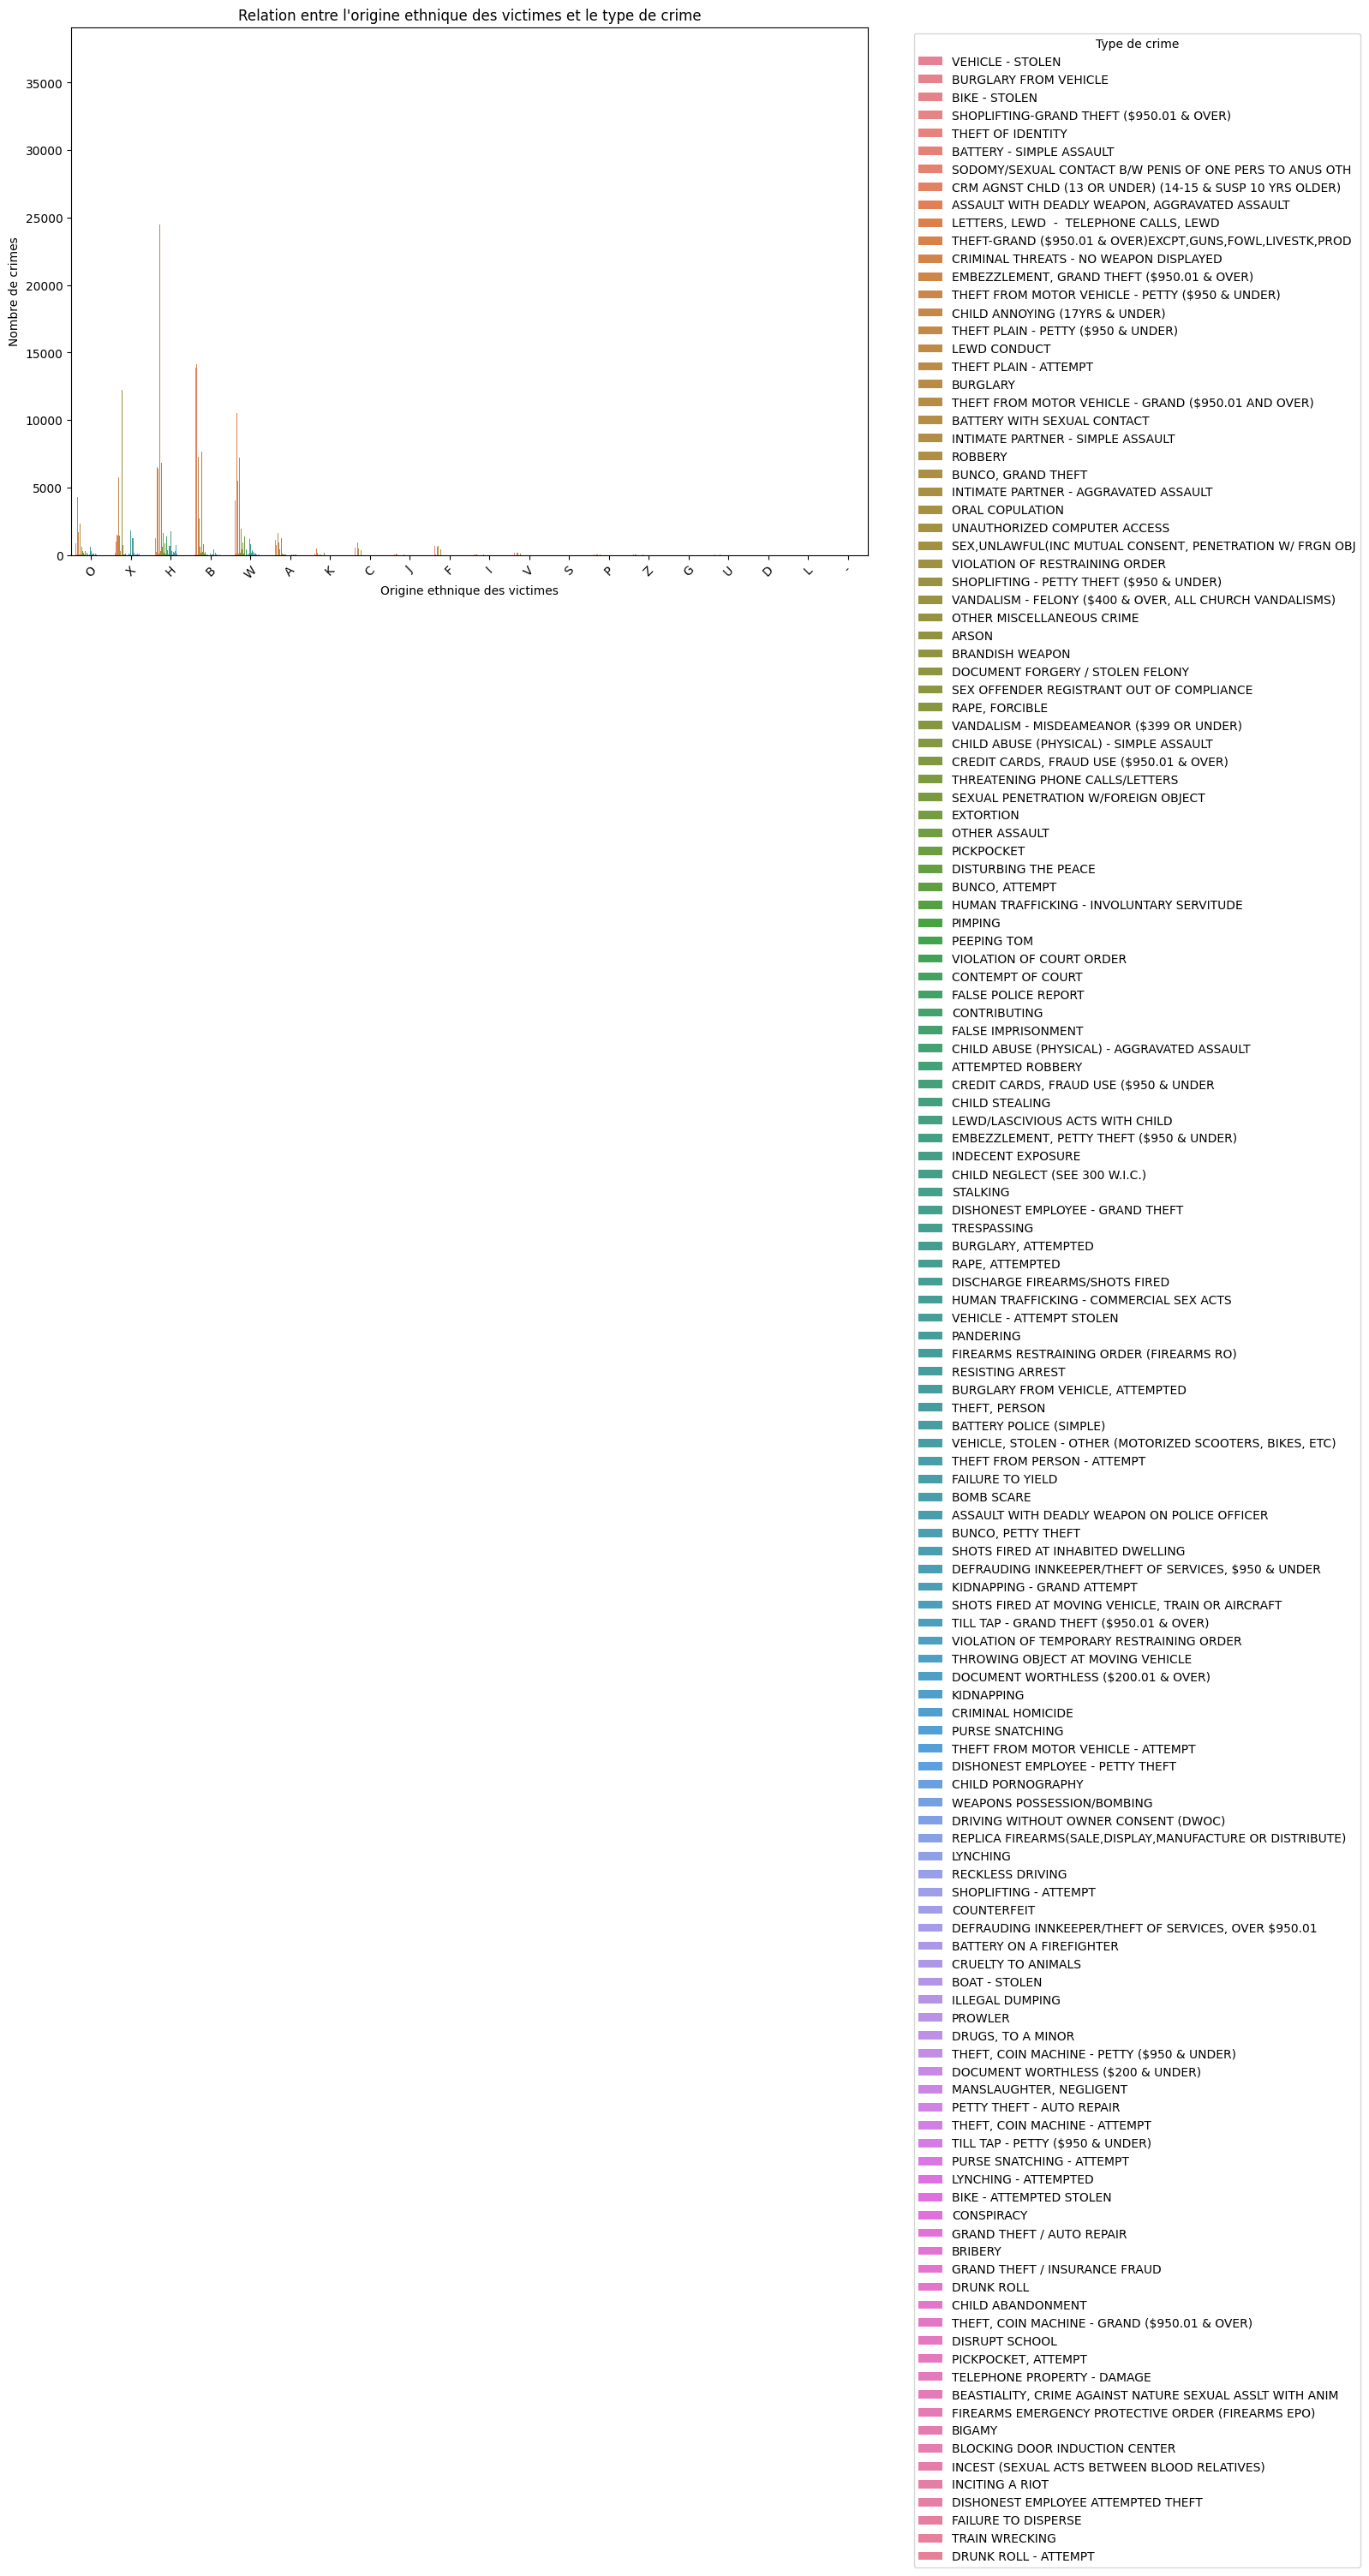

In [13]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Vict Descent', hue='Crm Cd Desc', data=df)
plt.title('Relation entre l\'origine ethnique des victimes et le type de crime')
plt.xlabel('Origine ethnique des victimes')
plt.ylabel('Nombre de crimes')
plt.legend(title='Type de crime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()





- ### <span style="color:#007bff">Relation entre le statut du crime et le sexe des victimes</span>


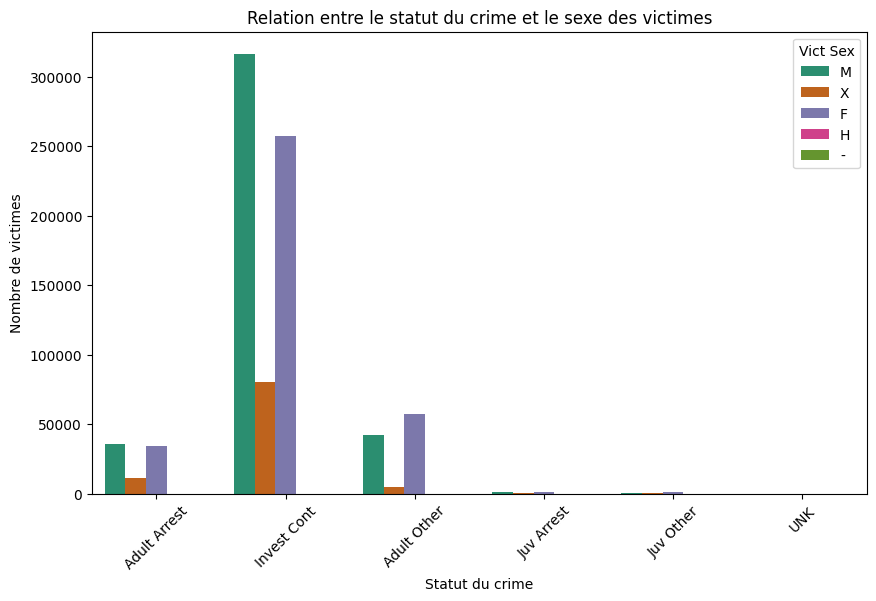

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Status Desc', hue='Vict Sex', data=df, palette='Dark2')
plt.title('Relation entre le statut du crime et le sexe des victimes')
plt.xlabel('Statut du crime')
plt.ylabel('Nombre de victimes')
plt.xticks(rotation=45)
plt.show()


# <span style="color:#007bff">Réprésentation des crimes au fil du temps</span>


- ### <span style="color:#007bff">Tendances de la criminalité au fil du temps</span>


C:\Users\user\AppData\Local\Temp\ipykernel_30436\1386877382.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
C:\Users\user\AppData\Local\Temp\ipykernel_30436\1386877382.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])


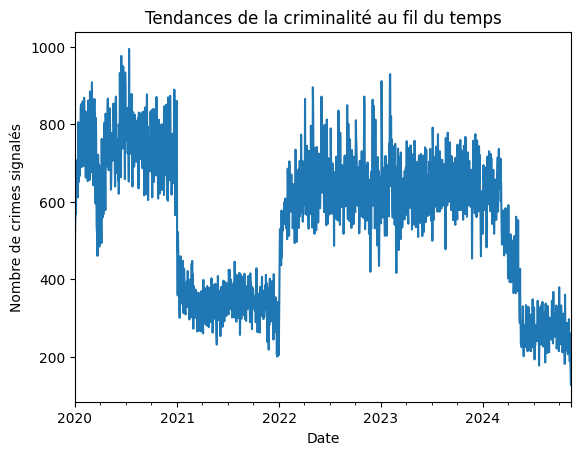

In [17]:
# Convertir les colonnes de date en datetime
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Tendances de la criminalité au fil du temps
df['Date Rptd'].value_counts().sort_index().plot()
plt.xlabel('Date')
plt.ylabel('Nombre de crimes signalés')
plt.title('Tendances de la criminalité au fil du temps')
plt.show()

- ### <span style="color:#007bff">Convertir la colonne 'DATE OCC' en datetime avec le bon format</span>


In [18]:
# Convertir la colonne 'DATE OCC' en datetime avec le bon format
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
# Extraire l'année, le mois, le jour et l'heure
df['YEAR OCC'] = df['DATE OCC'].dt.year
df['MONTH OCC'] = df['DATE OCC'].dt.month
df['DAY OCC'] = df['DATE OCC'].dt.day
df['HOUR OCC'] = df['DATE OCC'].dt.hour

- ### <span style="color:#007bff">Nombre de Crimes par Mois de toutes les années "2020-2024"</span>


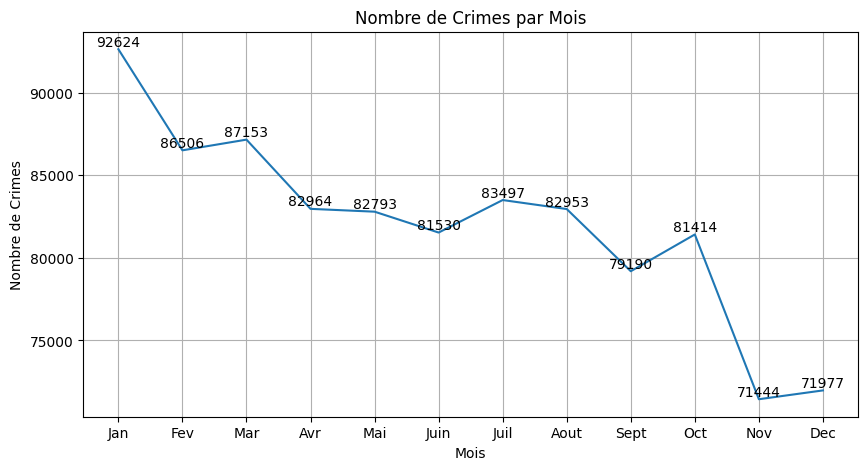

In [19]:
# Grouper les données par mois et compter le nombre de crimes
crimes_monthly = df['MONTH OCC'].value_counts().sort_index()

# Créer la courbe
plt.figure(figsize=(10,5))
crimes_monthly.plot(kind='line')
plt.title('Nombre de Crimes par Mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de Crimes')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aout', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Ajouter les chiffres sur le graphique
for i, count in enumerate(crimes_monthly):
    plt.annotate(str(count), (i+1, count), ha='center', va='bottom')

plt.show()

- ### <span style="color:#007bff">Nombre de Crimes par Mois pour Chaque Année "2020-2024"</span>


posx and posy should be finite values
posx and posy should be finite values


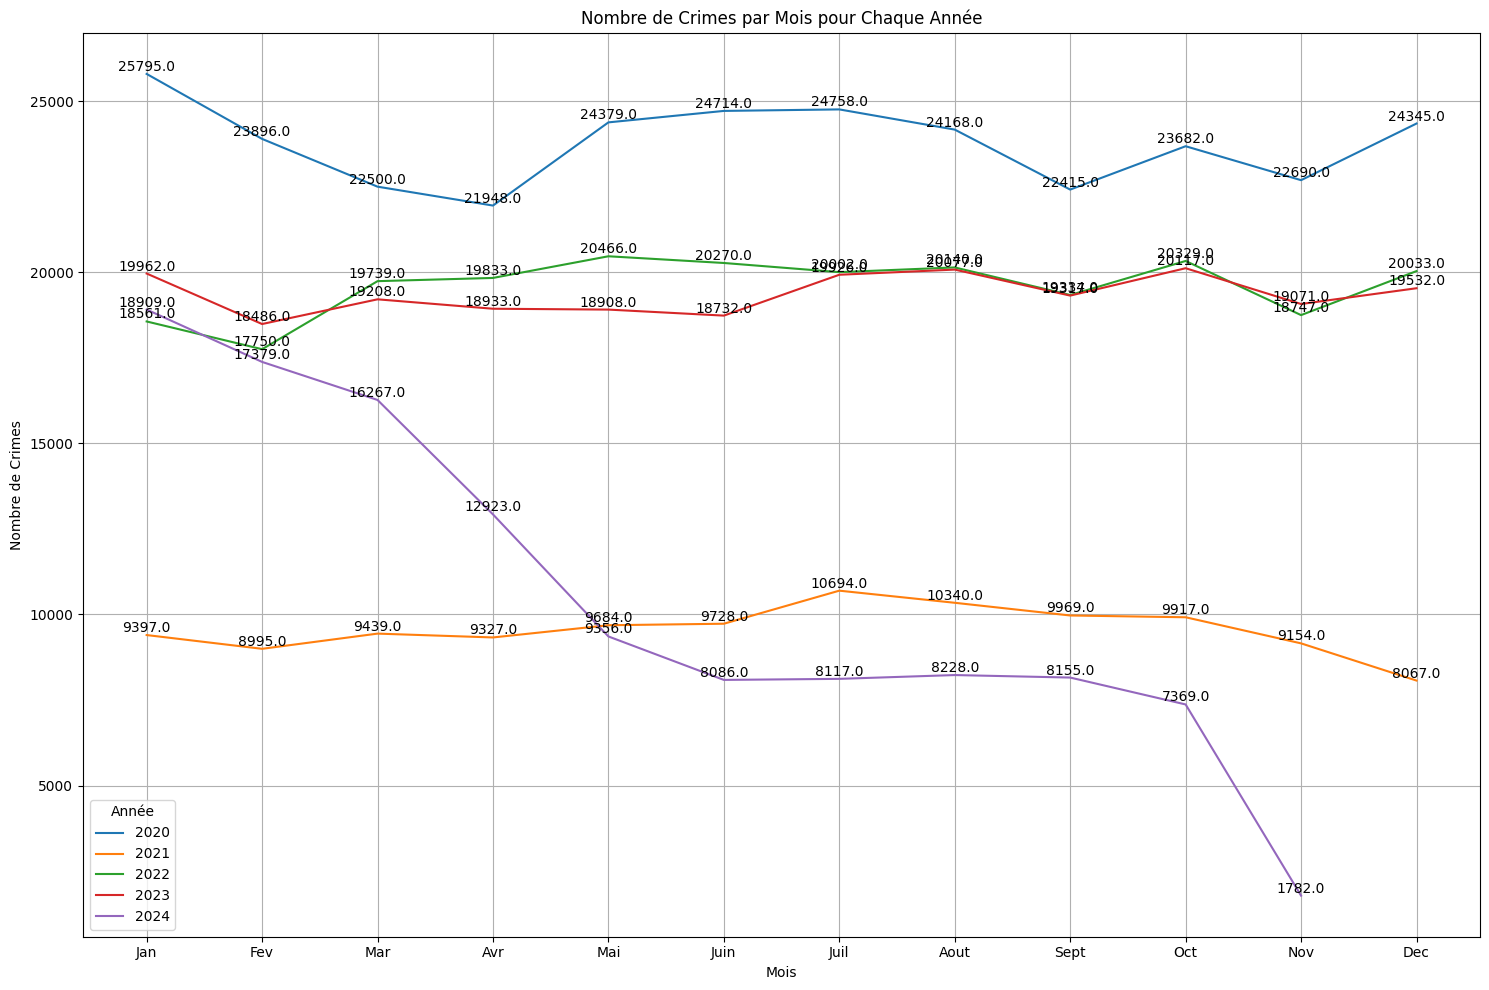

In [20]:

# Convertir les colonnes de date en datetime si ce n'est pas déjà fait
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Extraire l'année et le mois de la colonne 'DATE OCC'
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month

# Grouper les données par année et mois et compter le nombre de crimes
crimes_yearly_monthly = df.groupby(['Year', 'Month']).size().unstack()

# Vérifier si l'année 2023 est présente dans les données
if 2023 in crimes_yearly_monthly.index:
    # Filtrer les données pour 2023 jusqu'au mois de septembre
    data_2023 = crimes_yearly_monthly.loc[2023].dropna()

    # Créer le graphique avec une taille plus grande
    plt.figure(figsize=(15, 10))

    # Parcourir chaque année
    for year, data in crimes_yearly_monthly.iterrows():
        plt.plot(data.index, data.values, label=year)

        # Ajouter les chiffres sur les courbes
        for i, count in enumerate(data.values):
            plt.text(i+1, count, str(count), ha='center', va='bottom')

    # Ajouter les détails au graphique
    plt.title('Nombre de Crimes par Mois pour Chaque Année')
    plt.xlabel('Mois')
    plt.ylabel('Nombre de Crimes')
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aout', 'Sept', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Année')

    # Afficher le graphique
    plt.grid(True)
    plt.tight_layout()  # Pour éviter les coupures
    plt.show()
else:
    print("Les données pour l'année 2023 sont manquantes jusqu'au mois de septembre.")


# <span style="color:#007bff">Réprésentation des Crimes sur une Carte de chaleur</span>


In [21]:

# Calculer le nombre de crimes par coordonnées
crime_counts = df.groupby(['LAT', 'LON']).size().reset_index(name='Count')

# Supprimer les lignes avec des valeurs manquantes dans les colonnes LAT et LON
crime_counts = crime_counts.dropna(subset=['LAT', 'LON'])

# Créer une carte centrée sur Los Angeles
map_heat = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Convertir les coordonnées en format compréhensible par Folium
heat_data = [[row['LAT'], row['LON']] for index, row in crime_counts.iterrows()]

# Utiliser K-means pour regrouper les crimes
num_clusters = 10  # Choisissez le nombre de clusters selon votre préférence
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(heat_data)
crime_counts['Cluster'] = kmeans.labels_

# Ajouter la carte de chaleur à la carte
HeatMap(heat_data, max_val=max(crime_counts['Count'])).add_to(map_heat)

# Ajouter les clusters à la carte
for cluster in range(num_clusters):
    cluster_data = crime_counts[crime_counts['Cluster'] == cluster]
    cluster_center = [cluster_data['LAT'].mean(), cluster_data['LON'].mean()]
    num_crimes = len(cluster_data)
    
    # Gérer les couleurs en fonction du nombre de crimes
    if num_crimes > 50:
        color = 'red'
    elif num_crimes < 10:
        color = 'green'
    else:
        color = 'yellow'
    
    popup_text = f"<b>Cluster {cluster+1}</b><br>Nombre de Crimes: {num_crimes}"
    folium.Marker(location=cluster_center, popup=popup_text, icon=folium.Icon(color=color)).add_to(map_heat)

# Créer des polygones autour des clusters
gdf = gpd.GeoDataFrame(crime_counts, geometry=gpd.points_from_xy(crime_counts['LON'], crime_counts['LAT']))
gdf['Cluster'] = kmeans.labels_
cluster_polygons = []
for cluster_id in range(num_clusters):
    cluster_gdf = gdf[gdf['Cluster'] == cluster_id]
    if not cluster_gdf.empty:
        cluster_polygon = cluster_gdf.unary_union.convex_hull
        cluster_polygons.append(cluster_polygon)
        geojson = cluster_polygon.__geo_interface__
        style_function = lambda x: {'fillColor': 'blue', 'color': 'blue'}
        folium.GeoJson(geojson, style_function=style_function, name=f'Cluster {cluster_id+1}').add_to(map_heat)

# Ajouter un titre à la carte
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Carte de Chaleur des Crimes</b></h3>
             '''
map_heat.get_root().html.add_child(folium.Element(title_html))

# Ajouter une légende
legend_html = '''
             <div style="position: fixed; 
                          bottom: 50px; left: 50px; width: 150px; height: 90px; 
                          background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                          ">&nbsp; Légende <br>
                           &nbsp; Plus de crimes &nbsp; 
                           <div style="width:30px;height:10px;border:1px solid grey;background-color:#FFD700;display:inline-block;"></div>
                           <br>
                           &nbsp; Moins de crimes &nbsp; 
                           <div style="width:30px;height:10px;border:1px solid grey;background-color:#FF4500;display:inline-block;"></div>
             </div>
             '''
map_heat.get_root().html.add_child(folium.Element(legend_html))

# Sauvegarder la carte
map_heat.save('carte_chaleur_crimes_modifiee.html')

C:\Users\user\AppData\Local\Temp\ipykernel_30436\4117374214.py:19: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data, max_val=max(crime_counts['Count'])).add_to(map_heat)
C:\Users\user\AppData\Local\Temp\ipykernel_30436\4117374214.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_polygon = cluster_gdf.unary_union.convex_hull
C:\Users\user\AppData\Local\Temp\ipykernel_30436\4117374214.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_polygon = cluster_gdf.unary_union.convex_hull
C:\Users\user\AppData\Local\Temp\ipykernel_30436\4117374214.py:45: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cluster_polygon = cluster_gdf.unary_union.convex_hull
C:\Users\user\AppData\Local\Temp\ipykernel_30436\4117374214.py:45: Deprecat

Le code commence par analyser les données géographiques des crimes en Los Angeles en regroupant les crimes selon leurs coordonnées géographiques (`LAT`, `LON`). Tout d'abord, il calcule le nombre de crimes pour chaque paire de coordonnées en utilisant la fonction `groupby`, puis élimine les lignes contenant des valeurs manquantes dans ces colonnes avec `dropna`.

Ensuite, une carte interactive est créée à l'aide de la bibliothèque `folium` et centrée sur Los Angeles. L'algorithme K-means est utilisé pour regrouper les points de crime en 10 clusters. Ce processus permet d'identifier des zones de forte ou faible criminalité, et chaque cluster se voit attribuer une couleur en fonction du nombre de crimes qu'il contient. Des marqueurs sont placés à la moyenne des coordonnées de chaque cluster, affichant le nombre de crimes dans une fenêtre contextuelle lorsqu'on clique dessus.

Pour délimiter visuellement les zones des clusters, des polygones convexes sont créés autour des points de chaque cluster, ce qui permet de mieux visualiser l'ampleur de la criminalité dans différentes zones de la ville. Ces polygones sont ajoutés à la carte en tant que géométries avec `GeoJson`.

Une fois la carte créée, un titre est ajouté en haut de la carte pour fournir un contexte à l'utilisateur. Une légende est également incluse pour aider à comprendre la signification des couleurs des marqueurs, indiquant les zones avec plus ou moins de crimes.

Finalement, la carte interactive complète, incluant les clusters, les marqueurs, les polygones et les éléments de légende, est sauvegardée sous forme de fichier HTML, permettant à l'utilisateur de l'ouvrir et de l'explorer directement dans un navigateur web. Cette carte offre ainsi une représentation visuelle de la répartition géographique de la criminalité à Los Angeles.


# <span style="color:#007bff">PRÉVISION DES DONNÉES</span>



L'objectif de cette analyse est de prévoir les zones géographiques où les crimes auront lieu à Los Angeles entre 2020 et 2024. Afin d’y parvenir, nous avons sélectionné plusieurs caractéristiques du jeu de données des crimes passés, qui nous semblent pertinentes pour la prédiction des zones des futurs crimes. Ces caractéristiques comprennent des informations temporelles, géographiques et contextuelles. Voici un aperçu détaillé des variables choisies :

1. **DATE OCC** (Date de l'incident) : La date exacte à laquelle chaque crime a été commis peut fournir des informations cruciales sur la saisonnalité et les tendances temporelles des crimes. Par exemple, les crimes peuvent être plus fréquents pendant certaines périodes de l'année ou à des moments particuliers de la journée. Ainsi, cette variable est décomposée en trois nouvelles variables :
   - **MONTH OCC** : Le mois de l'incident, permettant de capturer les tendances saisonnières.
   - **DAY OCC** : Le jour du mois, pour observer des modèles sur des jours spécifiques.
   - **HOUR OCC** : L'heure de l'incident, permettant d'identifier des tendances horaires, comme des crimes plus fréquents la nuit ou en fin de journée.

2. **LAT et LON** (Latitude et Longitude) : Ces coordonnées géographiques nous aident à localiser précisément chaque crime sur une carte. Elles sont cruciales pour détecter des clusters de crimes dans certaines zones géographiques et permettre au modèle d’identifier des zones à risque élevé. De plus, la combinaison de ces variables avec d'autres facteurs, comme les types de crimes, peut améliorer la précision des prédictions.

3. **AREA NAME** (Nom de la zone) : Cette variable représente les différentes zones de Los Angeles, chaque zone ayant des caractéristiques démographiques, sociales et économiques distinctes. Nous avons transformé cette variable en des valeurs numériques pour faciliter son utilisation dans les modèles de machine learning. Par exemple :
       - 'Pacific': 0,
    - 'Central': 1,
    - '77th Street': 2,
    - 'Wilshire': 3,
    - 'N Hollywood': 4,
    - 'Newton': 5,
    - 'Southwest': 6,
    - 'West LA': 7,
    - 'Hollywood': 8,
    - 'Northeast': 9,
    - 'Southeast': 10,
    - 'Devonshire': 11,
    - 'Olympic': 12,
    - 'Van Nuys': 13,
    - 'West Valley': 14,
    - 'Topanga': 15,
    - 'Harbor': 16,
    - 'Mission': 17,
    - 'Hollenbeck': 18,
    - 'Rampart': 19,
    - 'Foothill': 20
    
   Cette transformation permet au modèle d'analyser les tendances liées à chaque zone de manière numérique, facilitant ainsi l’apprentissage des zones où les crimes sont les plus fréquents.

L’utilisation de ces variables permet au modèle de tirer parti de diverses informations contextuelles (comme l’heure et la localisation) pour prédire avec précision les zones où les crimes pourraient survenir dans le futur. L’objectif est de créer un modèle capable de comprendre les tendances spatio-temporelles des crimes, en tenant compte des différentes influences de chaque variable.


- ### <span style="color:#007bff">Sélection des caractéristiques (X) et de la variable cible (y)</span>


In [23]:
from sklearn.linear_model import LinearRegression

X = df[['YEAR OCC', 'MONTH OCC', 'DAY OCC', 'HOUR OCC', 'LAT', 'LON']]
Y = df['AREA NAME']

In [24]:
# liste d'AREA NAME
Y = [
    'Pacific', 'Central', '77th Street', 'Wilshire', 'N Hollywood', 'Newton', 'Southwest',
    'West LA', 'Hollywood', 'Northeast', 'Southeast', 'Devonshire', 'Olympic', 'Van Nuys',
    'West Valley', 'Topanga', 'Harbor', 'Mission', 'Hollenbeck', 'Rampart', 'Foothill'
]
y = {name: idx for idx, name in enumerate(Y)}
Y = [
    'Pacific', 'Central', '77th Street', 'Wilshire', 'N Hollywood', 'Newton', 'Southwest',
    'West LA', 'Hollywood', 'Northeast', 'Southeast', 'Devonshire', 'Olympic', 'Van Nuys',
    'West Valley', 'Topanga', 'Harbor', 'Mission', 'Hollenbeck', 'Rampart', 'Foothill'
]
Y = [y[name] for name in Y]

df['AREA NAME'] = df['AREA NAME'].map(y)

L'intérêt de ce code est de **transformer les noms des zones géographiques (`AREA NAME`) en valeurs numériques** dans le DataFrame. Cela permet de :

1. **Faciliter l'analyse statistique et l'apprentissage automatique**, car les algorithmes de machine learning préfèrent souvent les données numériques.
2. **Standardiser les données** : Les modèles peuvent mieux gérer les zones géographiques sous forme d'indices numériques plutôt que de noms textuels.
3. **Optimiser les performances** : L'utilisation de valeurs numériques pour les zones améliore l'efficacité des calculs et la manipulation des données, en particulier pour les grands ensembles de données.


- ### <span style="color:#007bff">Le remplacement des valeurs manquantes des X et y par les moyennes arrondies à l'entier le plus proche</span>

In [58]:
# Calculer les moyennes arrondies à l'entier le plus proche pour remplacer les valeurs manquantes dans X et y
mean_values_rounded = df[['YEAR OCC', 'MONTH OCC', 'DAY OCC', 'HOUR OCC', 'LAT', 'LON']].mean().round()

# Remplacer les valeurs manquantes par les moyennes arrondies à l'entier le plus proche
df['YEAR OCC'].fillna(int(mean_values_rounded['YEAR OCC']), inplace=True)
df['MONTH OCC'].fillna(int(mean_values_rounded['MONTH OCC']), inplace=True)
df['DAY OCC'].fillna(int(mean_values_rounded['DAY OCC']), inplace=True)
df['HOUR OCC'].fillna(int(mean_values_rounded['HOUR OCC']), inplace=True)
df['LAT'].fillna(int(mean_values_rounded['LAT']), inplace=True)
df['LON'].fillna(int(mean_values_rounded['LON']), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_30436\4052165533.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['YEAR OCC'].fillna(int(mean_values_rounded['YEAR OCC']), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_30436\4052165533.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

### <span style="color:#007bff">Visualisation des valeurs manquantes dans les données</span>


<Axes: >

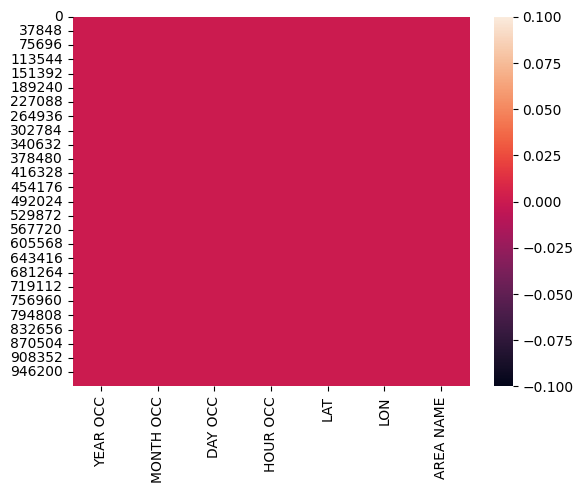

In [26]:
import seaborn as sns  # importer seaborn pour utiliser heatmap

# Sélection des colonnes spécifiques pour créer une sous-dataframe
df1 = df.loc[:, ['YEAR OCC', 'MONTH OCC', 'DAY OCC', 'HOUR OCC', 'LAT', 'LON', 'AREA NAME']]

# Affichage des valeurs nulles dans la sous-dataframe en utilisant heatmap
sns.heatmap(df1.isnull())

### <span style="color:#007bff">Creation d'une sous-dataframe pour nos variables de prévision</span>

In [42]:
# Calcul de la moyenne des valeurs présentes dans la colonne 'AREA NAME' (en évitant les NaN)
mean_area_name = np.nanmean(df1['AREA NAME'])

# Remplacement des NaN par la moyenne arrondie à l'entier le plus proche
df1['AREA NAME'].fillna(round(mean_area_name), inplace=True)

# Affichage pour vérification
df1

,YEAR OCC,MONTH OCC,DAY OCC,HOUR OCC,LAT,LON,AREA NAME
0,2020,3,1,0,34.0375,-118.3506,3
1,2020,2,8,0,34.0444,-118.2628,1
2,2020,11,4,0,34.0210,-118.3002,6
3,2020,3,10,0,34.1576,-118.4387,13
4,2020,8,17,0,34.0944,-118.3277,8
...,...,...,...,...,...,...,...
984040,2024,7,23,0,34.0362,-118.3284,3
984041,2024,1,15,0,34.0685,-118.2460,1
984042,2024,10,11,0,34.0675,-118.2240,18
984043,2024,4,24,0,34.0215,-118.2868,6


In [43]:
# Sauvegarder la sous-dataframe dans un fichier CSV
output_file = 'df1_subset.csv'  # Nom du fichier de sortie
df1.to_csv(output_file, index=False)
print(f"La sous-dataframe a été sauvegardée dans le fichier : {output_file}")

La sous-dataframe a été sauvegardée dans le fichier : df1_subset.csv


- ### <span style="color:#007bff">Sélection des caractéristiques (X) et de la variable cible (y) dans la sous dataframe</span>


In [44]:
X = df1[['YEAR OCC', 'MONTH OCC', 'DAY OCC', 'HOUR OCC', 'LAT', 'LON']]
Y = df1['AREA NAME']

**NB :** Notre jeu de données est volumineux et demande beaucoup de traitement. Après avoir exploré plusieurs modèles de régression, il est apparu qu'ils ne semblaient pas performants du tout sur notre ensemble de données. Toutefois, en utilisant des modèles de classification tels que Random Forest, KNN Classification et XGBRegressor, nous avons obtenu de bonnes réponses et des niveaux de précision satisfaisants. C'est pourquoi nous avons décidé de privilégier les modèles de classification pour la suite de notre analyse.

Ces modèles de classification se sont avérés robustes et capables de gérer des ensembles de données complexes avec des relations non linéaires. De plus, ils ont la capacité de traiter plusieurs types de caractéristiques, qu'elles soient numériques ou catégorielles, sans nécessiter beaucoup de prétraitement. Cette adaptabilité et cette capacité à gérer des données diverses ont renforcé notre choix en faveur des modèles de classification pour obtenir des prédictions plus précises sur l'âge des victimes dans notre ensemble de données.

# <span style="color:#007bff"> Entraînement et Évaluation</span>

<h2>Random Forest</h2>

- #### <span style="color:red">n_estimators=100</span>

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import joblib


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
random_forest_model.fit(X_train, Y_train)

# Prédire les classes sur l'ensemble de test
pre = random_forest_model.predict(X_test)

# Calculer le score de précision
accuracy = accuracy_score(Y_test, pre)

# Afficher le score de précision et le rapport de classification
print(f"Score de précision : {accuracy}")
print("Rapport de classification :\n", classification_report(Y_test, pre))



Score de précision : 0.9929220716532272
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11467
           1       0.99      0.99      0.99     13746
           2       0.99      0.99      0.99     11756
           3       0.99      0.99      0.99      9705
           4       0.99      0.99      0.99      9785
           5       0.99      0.99      0.99      9118
           6       1.00      0.99      1.00     11179
           7       0.99      0.99      0.99      8957
           8       0.99      0.99      0.99     10300
           9       0.99      0.99      0.99      8554
          10       0.99      1.00      1.00     10204
          11       1.00      0.99      0.99      8180
          12       0.99      0.99      0.99      9650
          13       0.99      0.99      0.99      8535
          14       1.00      0.99      1.00      8184
          15       1.00      1.00      1.00      7982
          16

- #### <span style="color:red">n_estimators=10</span>


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import joblib


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Entraîner le modèle sur les données d'entraînement
random_forest_model.fit(X_train, Y_train)

# Prédire les classes sur l'ensemble de test
predd = random_forest_model.predict(X_test)

# Calculer le score de précision
accuracy = accuracy_score(Y_test, predd)

# Afficher le score de précision et le rapport de classification
print(f"Score de précision : {accuracy}")
print("Rapport de classification :\n", classification_report(Y_test, predd))



Score de précision : 0.9919973171958599
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11467
           1       0.99      0.99      0.99     13746
           2       0.99      0.99      0.99     11756
           3       0.99      0.99      0.99      9705
           4       0.99      0.99      0.99      9785
           5       0.99      0.98      0.99      9118
           6       1.00      0.99      1.00     11179
           7       0.99      0.99      0.99      8957
           8       0.99      0.99      0.99     10300
           9       0.98      0.98      0.98      8554
          10       0.99      1.00      1.00     10204
          11       0.99      0.99      0.99      8180
          12       0.99      0.99      0.99      9650
          13       0.99      0.99      0.99      8535
          14       1.00      0.99      0.99      8184
          15       1.00      1.00      1.00      7982
          16

- #### <span style="color:red">n_estimators=500</span>


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import joblib


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=500, random_state=42)

# Entraîner le modèle sur les données d'entraînement
random_forest_model.fit(X_train, Y_train)

# Prédire les classes sur l'ensemble de test
predi = random_forest_model.predict(X_test)

# Calculer le score de précision
accuracy = accuracy_score(Y_test, predi)

# Afficher le score de précision et le rapport de classification
print(f"Score de précision : {accuracy}")
print("Rapport de classification :\n", classification_report(Y_test, predi))



Score de précision : 0.9929271527216743
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11467
           1       0.99      0.99      0.99     13746
           2       0.99      0.99      0.99     11756
           3       0.99      0.99      0.99      9705
           4       0.99      0.99      0.99      9785
           5       0.99      0.99      0.99      9118
           6       1.00      1.00      1.00     11179
           7       0.99      0.99      0.99      8957
           8       0.99      0.99      0.99     10300
           9       0.99      0.99      0.99      8554
          10       0.99      1.00      1.00     10204
          11       1.00      0.99      0.99      8180
          12       0.99      0.99      0.99      9650
          13       0.99      0.99      0.99      8535
          14       1.00      0.99      1.00      8184
          15       0.99      1.00      1.00      7982
          16

Les trois modèles Random Forest, utilisant des valeurs différentes pour le paramètre **n_estimators**, ont tous montré des performances exceptionnelles en termes de précision, avec des scores proches de **0.992**. Cela indique que le modèle est robuste et peu sensible à des variations modestes du nombre d'arbres dans la forêt.

Cependant, une augmentation significative de **n_estimators** (de 100 à 500) n'a pas apporté d'amélioration notable en termes de précision, suggérant que **n_estimators=100** est suffisant pour obtenir un bon compromis entre performance et coût computationnel. Le modèle avec **n_estimators=10**, bien qu'un peu moins précis, reste une option viable pour des cas où les ressources sont limitées.

Ainsi, pour des tâches similaires, il peut être recommandé d'utiliser un **n_estimators** autour de 100, car cela garantit un excellent niveau de précision tout en réduisant le temps d'exécution.

<h2>XGBRegressor</h2>

In [69]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Prédire l'âge des victimes sur l'ensemble de test
predic = xgb_model.predict(X_test)

# Convertir les prédictions en classes (arrondir aux entiers les plus proches)
predictions_rounded = [round(pred) for pred in predic]

# Calculer le score de précision
accuracy = accuracy_score(y_test, predictions_rounded)

# Afficher le score de précision et le rapport de classification
print(f"Score de précision : {accuracy}")
print("Rapport de classification :\n", classification_report(y_test, predictions_rounded))

Score de précision : 0.9350995127255359
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     11467
           1       0.99      0.90      0.94     13746
           2       0.92      0.95      0.93     11756
           3       0.93      0.91      0.92      9705
           4       0.87      0.91      0.89      9785
           5       0.89      0.93      0.91      9118
           6       0.93      0.97      0.95     11179
           7       0.95      0.95      0.95      8957
           8       0.95      0.94      0.94     10300
           9       0.95      0.90      0.93      8554
          10       0.94      0.95      0.94     10204
          11       0.94      0.96      0.95      8180
          12       0.95      0.94      0.95      9650
          13       0.92      0.93      0.92      8535
          14       0.92      0.96      0.94      8184
          15       0.96      0.98      0.97      7982
          16

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

<h2>KNN Classification</h2>

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialiser le modèle KNN pour la classification avec k=5 (vous pouvez modifier cette valeur selon votre besoin)
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Entraîner le modèle sur les données d'entraînement
knn_classifier.fit(X_train, y_train)

# Prédire les classes sur l'ensemble de test
predict = knn_classifier.predict(X_test)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, predict)

# Afficher la précision du modèle et d'autres mesures de classification
print(f"Précision du modèle : {accuracy}")
print("Rapport de classification :\n", classification_report(y_test, predict))


Précision du modèle : 0.9092063879192517
Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     11467
           1       0.87      0.98      0.92     13746
           2       0.90      0.91      0.90     11756
           3       0.87      0.88      0.88      9705
           4       0.90      0.95      0.92      9785
           5       0.91      0.84      0.88      9118
           6       0.89      0.88      0.89     11179
           7       0.93      0.88      0.91      8957
           8       0.90      0.95      0.92     10300
           9       0.89      0.82      0.86      8554
          10       0.95      0.96      0.95     10204
          11       0.92      0.88      0.90      8180
          12       0.88      0.92      0.90      9650
          13       0.87      0.92      0.89      8535
          14       0.92      0.86      0.89      8184
          15       0.95      0.96      0.96      7982
          1

## <span style="color:#007bff">Évaluation des Modèles pour la Prédiction de la Zone de Crimes</span>

Plusieurs modèles ont été testés pour évaluer leur capacité à prédire la zone des crimes en fonction des données disponibles. Voici les résultats obtenus :  

| **Modèle**              | **Score de Précision** |  
|--------------------------|------------------------|  
| **Random Forest**        | **99%**               |  
| **XGBRegressor**         | 93%                   |  
| **KNN Classification**   | 90%                   |  

### Analyse des Résultats  

1. **Random Forest**  
   - Le modèle Random Forest a montré la meilleure performance avec un score de précision de **99%**.  
   - Cette précision élevée est attribuable à la capacité de Random Forest à gérer des ensembles de données complexes, combinée à son aptitude à réduire le surapprentissage grâce à l'agrégation de nombreux arbres décisionnels.  

2. **XGBRegressor**  
   - Avec un score de précision de **93%**, XGBRegressor s'est également révélé performant.  
   - Cependant, ce modèle est initialement conçu pour la régression, ce qui explique une précision légèrement inférieure après conversion des prédictions en classes.  

3. **KNN Classification**  
   - Le modèle KNN a obtenu une précision de **90%**, ce qui reste acceptable mais inférieur aux deux autres modèles.  
   - KNN peut être sensible à la distribution des données et aux choix des hyperparamètres, ce qui peut expliquer ce résultat.

### Conclusion  

Le modèle **Random Forest** est clairement le plus performant pour la prédiction de la zone des crimes. Son efficacité en termes de précision et de robustesse en fait le choix privilégié pour cette tâche. **XGBRegressor** et **KNN Classification** restent des alternatives viables mais nécessitent des ajustements pour atteindre des performances comparables.  


- ### <span style="color:#007bff">L'arbre de décision avec notre model Random forest</span>

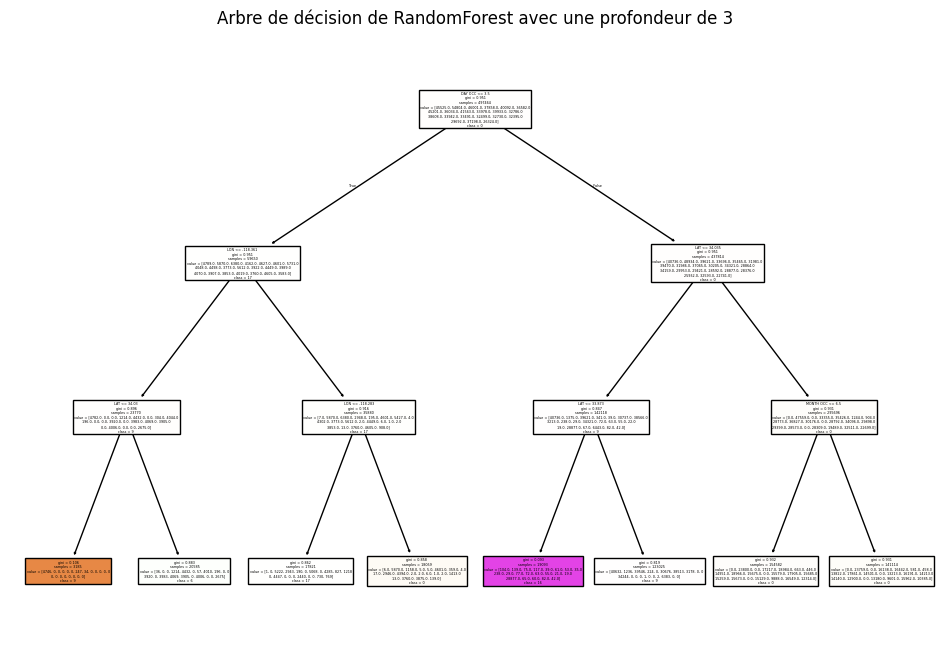

In [46]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

# Supposons que X_train et y_train soient déjà définis
# Initialiser le modèle RandomForestClassifier avec une profondeur d'arbre réduite
random_forest_model_shallow_tree = RandomForestClassifier(n_estimators=1, max_depth=3, random_state=42)

# Entraîner le modèle sur les données d'entraînement
random_forest_model_shallow_tree.fit(X_train, y_train)

# Sélectionner le premier arbre de la forêt
tree = random_forest_model_shallow_tree.estimators_[0]

# Afficher l'arbre de décision à l'aide de plot_tree de scikit-learn
plt.figure(figsize=(12, 8))  # Ajuster la taille du graphique
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=[str(c) for c in y_train.unique()])
plt.title("Arbre de décision de RandomForest avec une profondeur de 3")
plt.show()


- ### <span style="color:#007bff">La matrice de confusion</span>

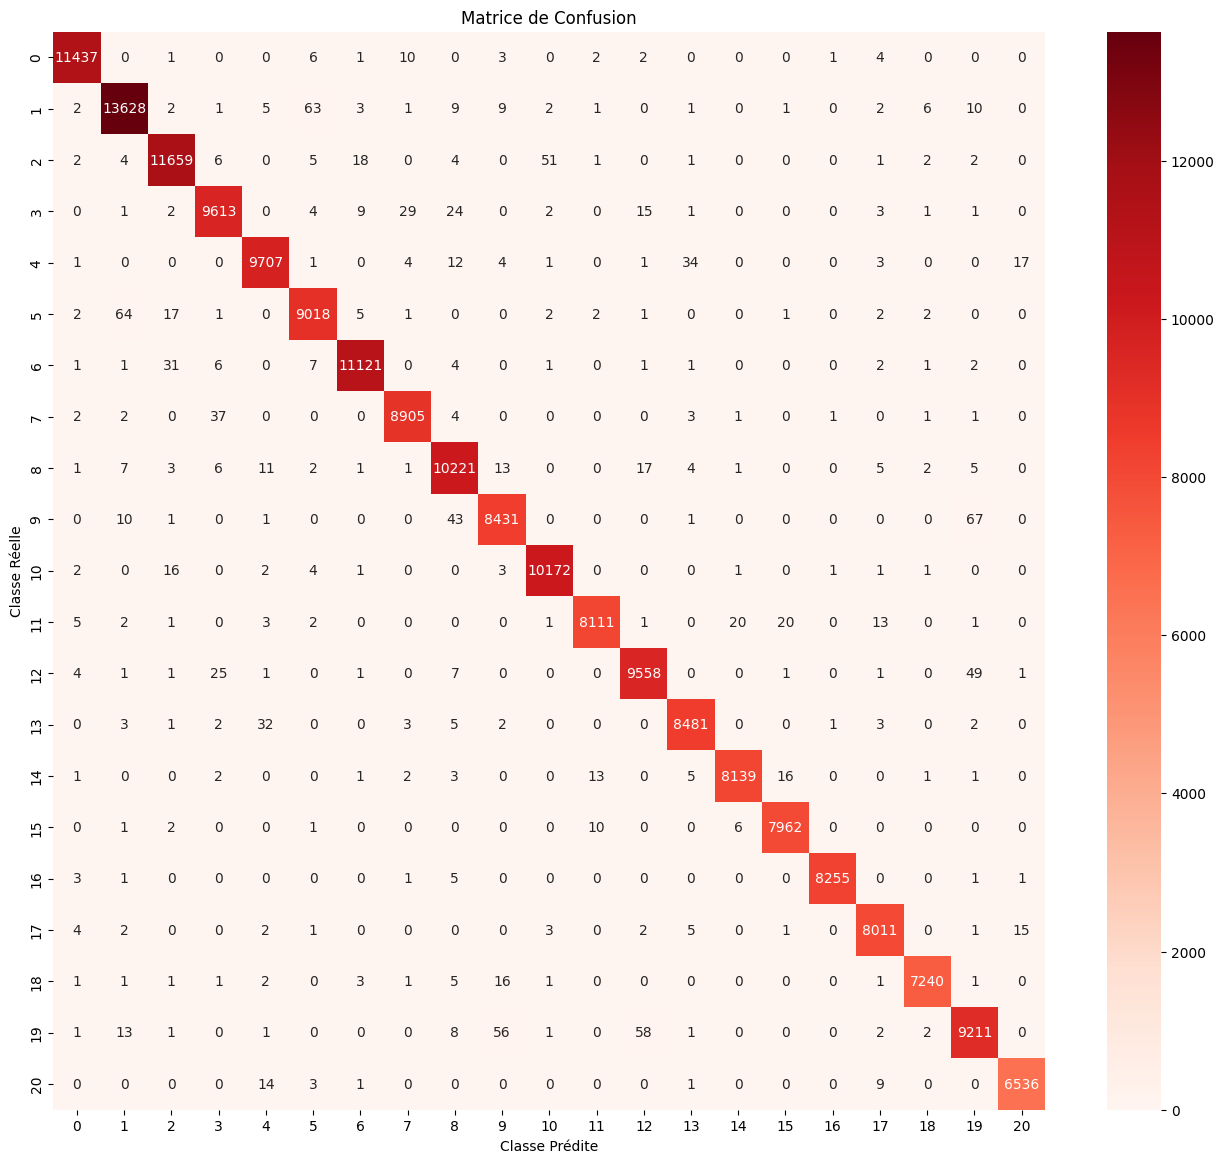

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, pre)

# Définir les étiquettes de classe
labels = sorted(set(y_test)) 

# Créer un heatmap de la matrice de confusion
plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()


La matrice de confusion montre que le modèle Random Forest a une excellente capacité à prédire correctement les classes, avec des valeurs élevées sur la diagonale principale, indiquant une forte précision globale. Cependant, certaines erreurs de classification persistent, notamment pour des classes spécifiques, mais elles restent relativement faibles.


## <span style="color:#007bff">Intégration de l'Âge des Victimes ('Vict Age') dans les Modèles de Prédiction des Zones de Crimes avec Random Forest</span>


In [62]:
# Ajouter 'Vict Age' aux caractéristiques
XX = df[['YEAR OCC', 'MONTH OCC', 'DAY OCC', 'HOUR OCC', 'LAT', 'LON', 'Vict Age']]
YY = df['AREA NAME']

# Diviser les données en ensembles d'entraînement et de test
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2, random_state=42)

# Initialiser le modèle RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
random_forest_model.fit(XX_train, YY_train)

# Prédire les classes sur l'ensemble de test
predictions = random_forest_model.predict(XX_test)

# Calculer le score de précision
accuracy = accuracy_score(YY_test, predictions)

# Afficher le score de précision et le rapport de classification
print(f"Score de précision : {accuracy}")
print("Rapport de classification :\n", classification_report(YY_test, predictions))


Score de précision : 0.9916721288152472
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11467
           1       0.99      0.99      0.99     13746
           2       0.99      0.99      0.99     11756
           3       0.99      0.99      0.99      9705
           4       0.99      0.99      0.99      9785
           5       0.99      0.99      0.99      9118
           6       1.00      0.99      1.00     11179
           7       0.99      0.99      0.99      8957
           8       0.98      0.99      0.99     10300
           9       0.99      0.98      0.98      8554
          10       0.99      1.00      1.00     10204
          11       1.00      0.99      0.99      8180
          12       0.99      0.99      0.99      9650
          13       0.99      0.99      0.99      8535
          14       1.00      0.99      0.99      8184
          15       0.99      1.00      1.00      7982
          16

- ### <span style="color:#007bff">La matrice de confusion</span>

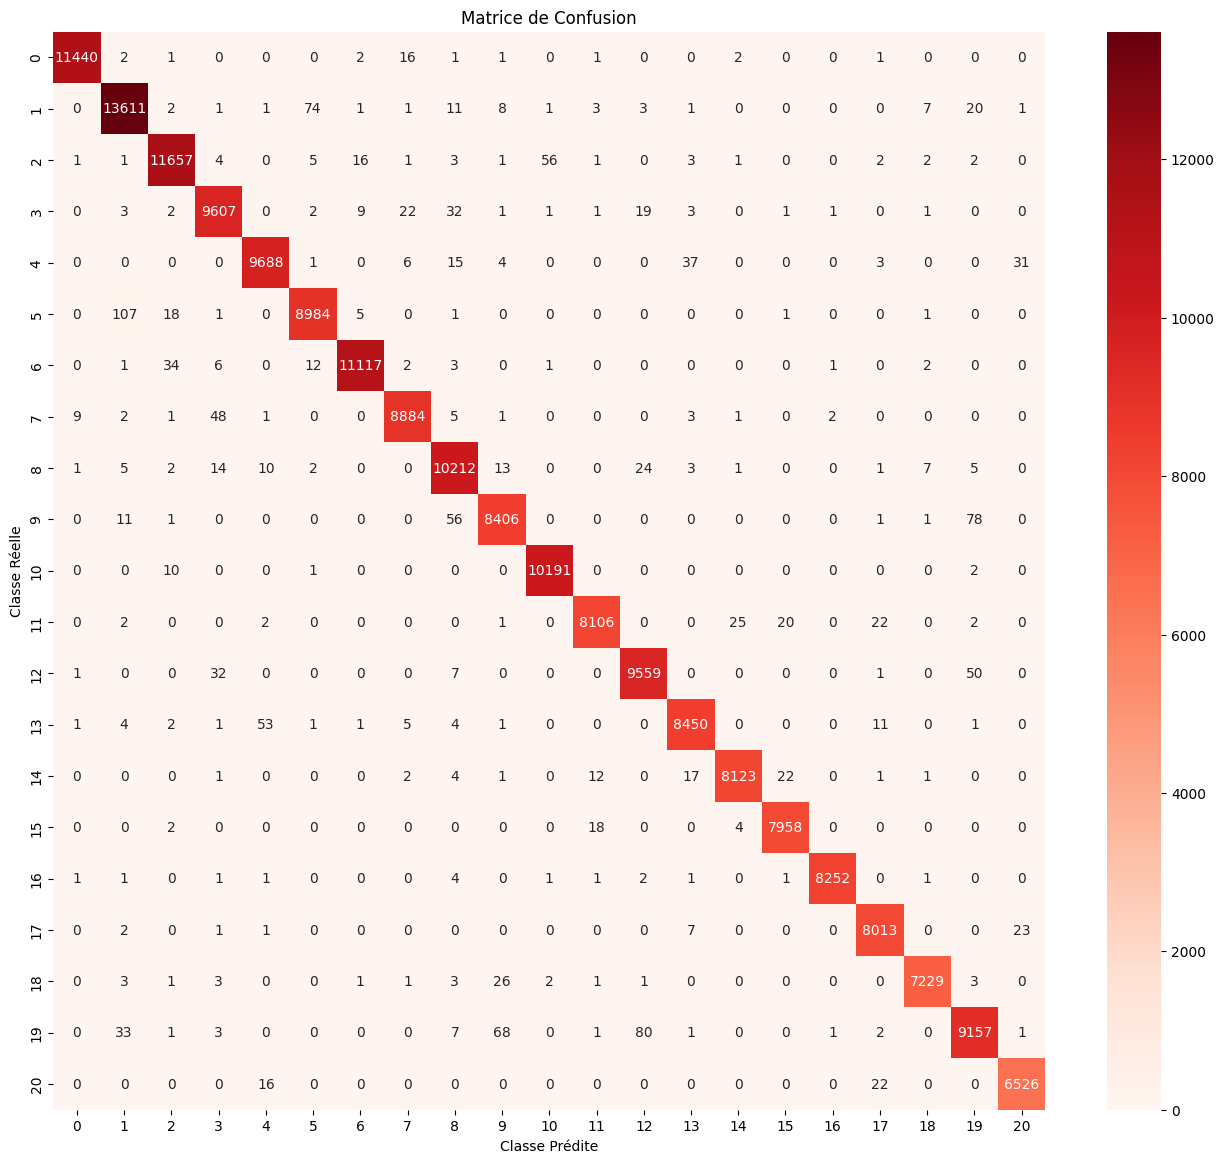

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(YY_test, predictions)

# Définir les étiquettes de classe
labels = sorted(set(y_test)) 

# Créer un heatmap de la matrice de confusion
plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()


Après l'ajout de la variable "Vict Age" aux caractéristiques du modèle, le score de précision reste proche de **99%**. Cela montre que l'inclusion de l'âge des victimes n'a pas entraîné de changement significatif dans les performances du modèle. Bien que l'information sur l'âge soit pertinente.

<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        .header {
            background-color:; 
            color: white; 
            height: 150px; 
            display: flex; 
            justify-content: center; 
            align-items: center; 
            font-size: 36px; 
            font-weight: bold; 
            border-radius: 15px;
            margin-bottom: 40px; 
        }
    </style>
</head>
<body>
    <div class="header">
    ------------------------------
    </div>
</body>
</html>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Conclusion du Projet d'Analyse des Modèles</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            background-color: #f4f4f4;
            margin: 0;
            padding: 0;
        }
        .container {
            max-width: 800px;
            margin: 30px auto;
            padding: 20px;
            background-color: #fff;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            border-radius: 8px;
        }
        h1 {
            color: #007bff;
            text-align: center;
        }
        p {
            font-size: 18px;
            color: #333;
            text-align: justify;
        }
        .conclusion {
            background-color: #f9f9f9;
            padding: 15px;
            border-left: 5px solid #007bff;
            margin-top: 20px;
        }
        .big-message {
            background-color: #007bff;
            color: white;
            font-size: 24px;
            text-align: center;
            padding: 20px;
            margin-top: 50px;
            font-weight: bold;
            border-radius: 10px;
        }
        .footer {
            text-align: center;
            margin-top: 40px;
            font-size: 14px;
            color: #777;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Conclusion du Projet d'Analyse des Modèles</h1>
        <p>
            Ce projet a permis de mettre en place plusieurs modèles de machine learning afin de prédire la zone des crimes à partir des données disponibles. Trois modèles principaux ont été utilisés : Random Forest, XGBoost et KNN Classification. Chacun de ces modèles a donné de bons résultats, avec une précision avoisinant les 99% pour Random Forest, 93% pour XGBoost, et 90% pour KNN.
        </p>
        <p>
            L'impact des différentes caractéristiques sur la performance des modèles a été exploré. Les résultats ont montré que l'ajout de nouvelles variables, telles que l'âge des victimes, n'a pas modifié de manière significative la précision des prédictions. Cependant, l'utilisation de Random Forest avec 100 arbres a montré des résultats particulièrement solides. De plus, la visualisation des matrices de confusion et l'analyse des scores de précision ont permis de mieux comprendre les erreurs de classification et d'affiner les décisions sur les modèles à privilégier.
        </p>
        <div class="conclusion">
            <p><strong>Conclusion :</strong> Les modèles de classification tels que Random Forest et XGBoost ont montré leur robustesse et leur capacité à gérer des ensembles de données complexes, avec des résultats solides et stables. Ce projet démontre l'efficacité de ces techniques pour des tâches de prédiction de zones géographiques sur la base de caractéristiques temporelles et géographiques. Les résultats obtenus sont encourageants pour des applications futures dans la prévision et l'analyse des crimes.</p>
        </div>
    </div>
    <div class="big-message">
        Prédiction de zones de crimes : Modèles performants et résultats solides à 99% !
    </div>
    <div class="footer">
        <p>&copy; 2024 - Analyse et Prédiction des Zones de Crimes</p>
    </div>
</body>
</html>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Analyse des Modèles de Prédiction</title>
    <style>
        /* Style global */
        body {
            font-family: 'Helvetica Neue', Arial, sans-serif;
            background-color: #f7f7f7;
            color: #333;
            margin: 0;
            padding: 0;
        }

        /* Conteneur principal */
        .container {
            max-width: 900px;
            margin: 50px auto;
            padding: 20px;
            background-color: #fff;
            border-radius: 15px;
            box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
        }

        /* Titre principal */
        h1 {
            text-align: center;
            color: #333;
            font-size: 2.5em;
            margin-bottom: 30px;
        }

        /* Paragraphes */
        p {
            font-size: 1.2em;
            line-height: 1.6;
            color: #555;
        }

        /* Message important */
        .big-message {
            background-color: #f9d342;
            color: #333;
            font-size: 1.5em;
            font-weight: bold;
            text-align: center;
            padding: 25px;
            border-radius: 10px;
            margin-top: 40px;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }

        /* Pied de page */
        .footer {
            text-align: center;
            font-size: 0.9em;
            color: #888;
            margin-top: 40px;
        }

        /* Liens */
        .footer a {
            text-decoration: none;
            color: #007bff;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Conclusion de l'Analyse des Modèles de Prédiction</h1>
        <p>
            Dans ce projet, nous avons testé différents modèles de prédiction pour classifier les zones de crimes en fonction des caractéristiques disponibles. Après une série d'expérimentations avec Random Forest, XGBRegressor et KNN Classification, il a été constaté que le modèle Random Forest s'est révélé le plus performant avec une précision de 99%. Les modèles XGBRegressor et KNN ont aussi montré des performances intéressantes mais légèrement inférieures avec des précisions respectives de 93% et 90%.
        </p>
        <div class="big-message">
            Random Forest a été le modèle le plus performant avec une précision de 99% !
        </div>
        <p>
            En conclusion, l'analyse des différents modèles a montré que Random Forest offrait la meilleure robustesse pour ce type de tâche de classification. Malgré l'intégration de nouvelles caractéristiques comme l'âge de la victime, l'amélioration de la précision n'a pas été significative, ce qui suggère que le modèle était déjà optimisé pour les données initiales. Cette étude met en lumière l'importance de choisir le bon modèle et de comprendre son comportement pour des prédictions plus fiables.
        </p>
    </div>

    <div class="footer">
        <p>&copy; 2024 - Analyse des Modèles de Prédiction | <a href="#">En savoir plus</a></p>
    </div>
</body>
</html>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Analyse des Modèles de Prédiction</title>
    <style>
        /* Style global */
        body {
            font-family: 'Helvetica Neue', Arial, sans-serif;
            background-color: #f7f7f7;
            color: #333;
            margin: 0;
            padding: 0;
        }

        /* Conteneur principal */
        .container {
            max-width: 900px;
            margin: 50px auto;
            padding: 20px;
            background-color: #fff;
            border-radius: 15px;
            box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
        }

        /* Titre principal */
        h1 {
            text-align: center;
            color: #333;
            font-size: 2.5em;
            margin-bottom: 30px;
        }

        /* Paragraphes */
        p {
            font-size: 1.2em;
            line-height: 1.6;
            color: #555;
        }

        /* Message important */
        .big-message {
            background-color: #f9d342;
            color: #333;
            font-size: 1.5em;
            font-weight: bold;
            text-align: center;
            padding: 25px;
            border-radius: 10px;
            margin-top: 40px;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }

        /* Pied de page */
        .footer {
            text-align: center;
            font-size: 0.9em;
            color: #888;
            margin-top: 40px;
        }

        /* Liens */
        .footer a {
            text-decoration: none;
            color: #007bff;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Conclusion de l'Analyse des Modèles de Prédiction</h1>
        <p>
            Dans ce projet, nous avons testé différents modèles de prédiction pour classifier les zones de crimes en fonction des caractéristiques disponibles. Après une série d'expérimentations avec Random Forest, XGBRegressor et KNN Classification, il a été constaté que le modèle Random Forest s'est révélé le plus performant avec une précision de 99%. Les modèles XGBRegressor et KNN ont aussi montré des performances intéressantes mais légèrement inférieures avec des précisions respectives de 93% et 90%.
        </p>
        <div class="big-message">
            Random Forest a été le modèle le plus performant avec une précision de 99% !
        </div>
        <p>
            En conclusion, l'analyse des différents modèles a montré que Random Forest offrait la meilleure robustesse pour ce type de tâche de classification. Malgré l'intégration de nouvelles caractéristiques comme l'âge de la victime, l'amélioration de la précision n'a pas été significative, ce qui suggère que le modèle était déjà optimisé pour les données initiales. Cette étude met en lumière l'importance de choisir le bon modèle et de comprendre son comportement pour des prédictions plus fiables.
        </p>
    </div>

    <div class="footer">
        <p>&copy; 2024 - Analyse des Modèles de Prédiction | <a href="#">En savoir plus</a></p>
    </div>
</body>
</html>


<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Analyse des Modèles de Prédiction</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f9;
            margin: 0;
            padding: 0;
            display: flex;
            flex-direction: column;
            justify-content: space-between;
            height: 100vh;
        }

        .content {
            flex-grow: 1;
            text-align: center;
            margin-top: 50px;
        }

        .big-message {
            font-size: 24px;
            font-weight: bold;
            color: #333;
            padding: 20px;
            margin: 0 10px;
            background-color: #e0f7fa;
            border: 2px solid #26c6da;
            border-radius: 8px;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            transition: transform 0.3s ease;
        }

        .big-message:hover {
            transform: scale(1.05);
        }

        .footer {
            background-color: #333;
            color: white;
            text-align: center;
            padding: 10px;
            position: relative;
            bottom: 0;
            width: 100%;
            font-size: 14px;
        }
    </style>
</head>
<body>

    <div class="content">
        <!-- Section avec un gros message -->
        <div class="big-message">
            Random Forest a été le modèle le plus performant avec une précision de 99% !
        </div>
    </div>

    <!-- Footer -->
    <div class="footer">
        <p>&copy; 2024 - Analyse des Modèles de Prédiction</p>
    </div>

</body>
</html>
